In [1]:
from fgbuster import harmonic_ilc_alm,CMB
import healpy as hp
import pysm3
import pysm3.units as u
import sys
import curvedsky as cs
import cmb
import os
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('../')
from utils import camb_clfile,cli
import mpi
import matplotlib.pyplot as plt
import pickle as pl
from database import surveys,noise

In [2]:
infolder = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/'
dnside = 512
lmax = 3*dnside -1
maskpath = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits'
fwhm = 30
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]

In [3]:
mask = hp.ud_grade(hp.read_map(maskpath),dnside)

In [4]:
class INST:
    def __init__(self,beam,frequency):
        self.Beam = beam
        self.fwhm = beam
        self.frequency = frequency
def get_cmb(idx):
    fname = os.path.join(infolder,f"cmb_sims_{idx:04d}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_noise_spectra(depth_i,depth_p):
    t = np.ones(lmax+1)*(np.radians(depth_i/60)**2)
    e = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    b = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    return t,e,b

def get_noise_alm(depth_i,depth_p):
    t,e,b = get_noise_spectra(depth_i,depth_p)
    t = hp.synalm(t,lmax=lmax)
    e = hp.synalm(e,lmax=lmax)
    b = hp.synalm(b,lmax=lmax)
    return t,e,b

def get_noise_map(depth_i,depth_p):
    t,e,b = get_noise_alm(depth_i,depth_p)
    return hp.alm2map([t,e,b],nside=dnside)

def get_fg(v):
    fname = os.path.join(fg_dir,f"{fg_str}_{int(v)}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_total_maps_1(idx,v,n_t,n_p,beam):
    bl = hp.gauss_beam(np.radians(beam/60),lmax=lmax)
    maps = hp.smoothing(get_cmb(idx) + get_fg(v),fwhm=np.radians(beam/60)) + get_noise_map(n_t,n_p)
    alms = hp.map2alm(maps*mask)
    hp.almxfl(alms[0],cli(bl),inplace=True)
    hp.almxfl(alms[1],cli(bl),inplace=True)
    hp.almxfl(alms[2],cli(bl),inplace=True)
    return alms

def get_total_maps_2(idx,v,n_t,n_p,beam):
    maps = hp.smoothing(get_cmb(idx) + get_fg(v),fwhm=np.radians(beam/60)) + get_noise_map(n_t,n_p)
    return hp.map2alm(maps*mask)

def get_maps_arr(idx,v,n_t,n_p,beam,which):
        arr = []
        for i in tqdm(range(len(v)),desc="Making map",unit='Freq'):
            if which == 1:
                arr.append(get_total_maps_1(idx,v[i],n_t[i],n_p[i],beam[i]))
            elif which == 2:
                arr.append(get_total_maps_2(idx,v[i],n_t[i],n_p[i],beam[i]))
            else:
                raise ValueError
        return np.array(arr)

In [33]:
sigma = 2.16
Tcmb  = 2.726e6
beam_fl = hp.gauss_beam(np.radians(fwhm/30),lmax=lmax)
Bl = np.reshape(beam_fl,(1,lmax+1))
invn = mask * (np.radians(sigma/60)/Tcmb)**-2
invN = np.reshape(np.array((invn,invn)),(2,1,hp.nside2npix(dnside)))
fg_dir = '/global/cscratch1/sd/lonappan/S4BIRD/FG'
fg_str = "s0d0"

In [6]:
table = surveys().get_table_dataframe("LITEBIRD_V1")
freqs = np.array(table.frequency)
beam = np.array(table.fwhm)
nlev_p = np.array(table.depth_p)
nlev_t = nlev_p/np.sqrt(2)

In [7]:
alms_1 = get_maps_arr(0,freqs,nlev_t,nlev_p,beam,1)

Making map: 100%|██████████| 15/15 [16:25<00:00, 65.68s/Freq]


In [8]:
alms_2 = get_maps_arr(0,freqs,nlev_t,nlev_p,beam,2)

Making map: 100%|██████████| 15/15 [16:01<00:00, 64.10s/Freq]


In [9]:
instrument = INST(None,freqs)
components = [CMB()]
bins = np.arange(1000) * 10

In [10]:
result1 = harmonic_ilc_alm(components, instrument,alms_1,bins)

In [11]:
result2 = harmonic_ilc_alm(components, instrument,alms_2,bins)

In [14]:
TEB1 = [result1.s[0,0],result1.s[0,1],result1.s[0,2]]
TEB2 = [result2.s[0,0],result2.s[0,1],result2.s[0,2]]

In [34]:
TEB1_ = [hp.almxfl(result1.s[0,0],beam_fl),hp.almxfl(result1.s[0,1],beam_fl),hp.almxfl(result1.s[0,2],beam_fl)]


In [17]:
TQU1 = hp.alm2map(TEB1,dnside)
TQU2 = hp.alm2map(TEB2,dnside)

In [37]:
TQU1_ = hp.alm2map(TEB1_,dnside)

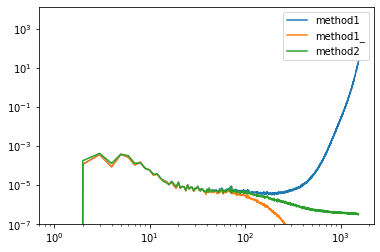

In [36]:
plt.loglog(hp.alm2cl(TEB1[2]),label='method1')
plt.loglog(hp.alm2cl(TEB1_[2]),label='method1_')
plt.loglog(hp.alm2cl(TEB2[2]),label='method2')
plt.ylim(10**-7,None)
plt.legend()

In [24]:
QU1 = np.reshape(np.array((TQU1[1],TQU1[2])),(2,1,hp.nside2npix(dnside)))/Tcmb
QU2 = np.reshape(np.array((TQU2[1],TQU2[2])),(2,1,hp.nside2npix(dnside)))/Tcmb

In [38]:
QU1_ = np.reshape(np.array((TQU1_[1],TQU1_[2])),(2,1,hp.nside2npix(dnside)))/Tcmb

In [25]:
invn = mask * (np.radians(sigma/60)/Tcmb)**-2
invN = np.reshape(np.array((invn,invn)),(2,1,hp.nside2npix(dnside)))

In [26]:
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]

In [27]:
E1,B1 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status1.txt')


In [39]:
E1_,B1_ =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU1_,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status1_.txt')


In [28]:
E2,B2 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU2,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status2.txt')



/tmp/ipykernel_13810/1858135492.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(100000000000000000, 1.6016827241718824e+29)

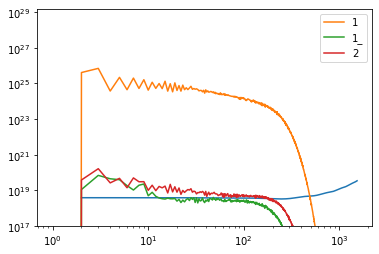

In [41]:
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B1),label='1')
plt.loglog(cs.utils.alm2cl(lmax,B1_),label='1_')
plt.loglog(cs.utils.alm2cl(lmax,B2),label='2')
plt.legend()
plt.ylim(10**17,None)

In [43]:
TQU_woFG1 = (hp.smoothing(get_cmb(0),fwhm=np.radians(fwhm/60)) + get_noise_map(1.5,sigma))*mask

In [45]:
TEB_woFG1 = hp.map2alm(TQU_woFG1)

In [68]:
TEB_woFG2 = TEB_woFG1.copy()

In [69]:
hp.almxfl(TEB_woFG2[0],cli(beam_fl),inplace=True)
hp.almxfl(TEB_woFG2[1],cli(beam_fl),inplace=True)
hp.almxfl(TEB_woFG2[2],cli(beam_fl),inplace=True)

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        3.83962374e-03+0.00000000e+00j, ...,
       -6.04429413e+20-2.56439145e+21j, -3.64916082e+21-1.35007871e+22j,
       -2.44053177e+21-9.36280749e+20j])

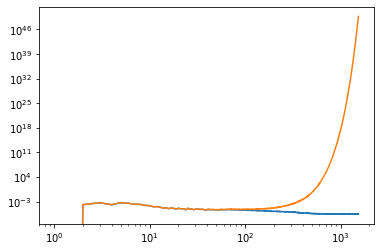

In [71]:
plt.loglog(hp.alm2cl(TEB_woFG1[2]))
plt.loglog(hp.alm2cl(TEB_woFG2[2]))

In [72]:
TQU_woFG2 = hp.alm2map(TEB_woFG2,dnside)

In [73]:
QU_woFG1 = np.reshape(np.array((TQU_woFG1[1],TQU_woFG1[2])),(2,1,hp.nside2npix(dnside)))/Tcmb
QU_woFG2 = np.reshape(np.array((TQU_woFG2[1],TQU_woFG2[2])),(2,1,hp.nside2npix(dnside)))/Tcmb

In [74]:
E_noFG1,B_noFG1 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU_woFG1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status1.txt')



In [75]:
E_noFG2,B_noFG2 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU_woFG2,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status1.txt')




/tmp/ipykernel_13810/2945304304.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(100000000000000000, 7.92861182893577e+22)

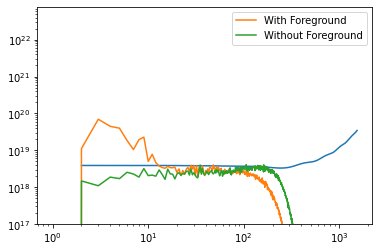

In [80]:
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B1_),label='With Foreground')
plt.loglog(cs.utils.alm2cl(lmax,B_noFG1),label='Without Foreground')
plt.legend()
plt.ylim(10**17,None)